## Feature Engineering and CV based Winners' Solutions

continued from eda_4_26

New in this notebook:
- Trained@2015-06-28, validated@2015-12-28, MAP@7=0.858, private LB=0.0302798, public LB=0.0298547

In [1]:
from santander_helper import *

In [2]:
# x_train_june15, y_train_june15 = create_train('2015-06-28', pattern_flag=True)

# params = {'objective': 'multi:softprob', 
#          'eta': 0.05, 
#          'max_depth': 8, 
#          'silent': 1, 
#          'num_class': len(target_cols),
#          'eval_metric': 'mlogloss',
#          'min_child_weight': 1,
#          'subsample': 0.7,
#          'colsample_bytree': 0.7,
#          'seed': 0}

In [3]:
param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0}
num_rounds = 100

history, model_dict, y_pred, y_sub = \
    train_test_month(param, num_rounds, '2015-06-28', '2016-05-28', 
    'eda_4_32.csv.gz', n_repeat=1, random_seed=0, n_features=None)

Train, validate, and predict, repetition 0 of 1
[0]	train-mlogloss:2.61033	val-mlogloss:2.64905	train-MAP@7:0.961887	val-MAP@7:0.951764
[1]	train-mlogloss:2.39088	val-mlogloss:2.44758	train-MAP@7:0.963635	val-MAP@7:0.952324
[2]	train-mlogloss:2.21336	val-mlogloss:2.28575	train-MAP@7:0.966981	val-MAP@7:0.960518
[3]	train-mlogloss:2.06752	val-mlogloss:2.14493	train-MAP@7:0.967791	val-MAP@7:0.963856
[4]	train-mlogloss:1.94376	val-mlogloss:2.02623	train-MAP@7:0.969139	val-MAP@7:0.965855
[5]	train-mlogloss:1.83356	val-mlogloss:1.9194	train-MAP@7:0.970036	val-MAP@7:0.966387
[6]	train-mlogloss:1.73542	val-mlogloss:1.82757	train-MAP@7:0.970667	val-MAP@7:0.966805
[7]	train-mlogloss:1.64887	val-mlogloss:1.74556	train-MAP@7:0.971048	val-MAP@7:0.966974
[8]	train-mlogloss:1.57529	val-mlogloss:1.67292	train-MAP@7:0.971395	val-MAP@7:0.967052
[9]	train-mlogloss:1.5046	val-mlogloss:1.60943	train-MAP@7:0.971935	val-MAP@7:0.967111
[10]	train-mlogloss:1.44061	val-mlogloss:1.54656	train-MAP@7:0.972194	val-

[91]	train-mlogloss:0.364734	val-mlogloss:0.456563	train-MAP@7:0.983502	val-MAP@7:0.969303
[92]	train-mlogloss:0.362814	val-mlogloss:0.454428	train-MAP@7:0.983604	val-MAP@7:0.969277
[93]	train-mlogloss:0.361135	val-mlogloss:0.452683	train-MAP@7:0.983682	val-MAP@7:0.96928
[94]	train-mlogloss:0.359387	val-mlogloss:0.45116	train-MAP@7:0.983775	val-MAP@7:0.969228
[95]	train-mlogloss:0.357624	val-mlogloss:0.449196	train-MAP@7:0.983891	val-MAP@7:0.969249
[96]	train-mlogloss:0.356018	val-mlogloss:0.447316	train-MAP@7:0.98402	val-MAP@7:0.969289
[97]	train-mlogloss:0.354557	val-mlogloss:0.445933	train-MAP@7:0.984103	val-MAP@7:0.969127
[98]	train-mlogloss:0.35297	val-mlogloss:0.444237	train-MAP@7:0.984229	val-MAP@7:0.969162
[99]	train-mlogloss:0.351445	val-mlogloss:0.44252	train-MAP@7:0.984274	val-MAP@7:0.969128
Validate logloss = 0.44252, MAP@7 = 0.96913, time = 19.81 min
--------------------------------------------------



In [4]:
history

repetition         0                              
data_set       train                 val          
metrics     mlogloss     MAP@7  mlogloss     MAP@7
0           2.610330  0.961887  2.649053  0.951764
1           2.390879  0.963635  2.447582  0.952324
2           2.213360  0.966981  2.285748  0.960518
3           2.067520  0.967791  2.144930  0.963856
4           1.943764  0.969139  2.026235  0.965855
5           1.833556  0.970036  1.919400  0.966387
6           1.735422  0.970667  1.827574  0.966805
7           1.648866  0.971048  1.745560  0.966974
8           1.575292  0.971395  1.672921  0.967052
9           1.504598  0.971935  1.609434  0.967111
10          1.440612  0.972194  1.546561  0.967447
11          1.380246  0.972523  1.487300  0.967868
12          1.324239  0.972656  1.432646  0.968120
13          1.272227  0.973026  1.382398  0.968187
14          1.226846  0.973090  1.338171  0.968246
15          1.182646  0.973339  1.296114  0.968306
16          1.140676  0.973584  1.253921  0.968252
17          1.102179  0.973728  1.216487  0.968402
18          1.066575  0.974012  1.179747  0.968543
19          1.033672  0.974105  1.147027  0.968434
20          1.000723  0.974271  1.115086  0.968300
21          0.971535  0.974303  1.085956  0.968234
22          0.943818  0.974430  1.057655  0.968423
23          0.915658  0.974510  1.029631  0.968374
24          0.890275  0.974763  1.005108  0.968368
25          0.865627  0.974856  0.979871  0.968392
26          0.842440  0.975094  0.955543  0.968444
27          0.820836  0.975227  0.935475  0.968408
28          0.799504  0.975373  0.912669  0.968558
29          0.779580  0.975458  0.893597  0.968629
..               ...       ...       ...       ...
70          0.417712  0.981268  0.515208  0.969080
71          0.414036  0.981410  0.510885  0.969059
72          0.410689  0.981472  0.507261  0.969058
73          0.407406  0.981608  0.503688  0.969169
74          0.404532  0.981707  0.500324  0.969202
75          0.401463  0.981922  0.496556  0.969201
76          0.398802  0.981898  0.493622  0.969213
77          0.396023  0.981910  0.490546  0.969138
78          0.393243  0.982122  0.487362  0.969147
79          0.390614  0.982202  0.484780  0.969195
80          0.388270  0.982322  0.482304  0.969177
81          0.385532  0.982511  0.479309  0.969016
82          0.383058  0.982588  0.476119  0.969068
83          0.380753  0.982755  0.473778  0.969133
84          0.378427  0.982797  0.471149  0.969109
85          0.376325  0.982911  0.468741  0.969190
86          0.374273  0.983044  0.466835  0.969098
87          0.372265  0.983083  0.464721  0.969141
88          0.370168  0.983187  0.462452  0.969124
89          0.368309  0.983347  0.460613  0.969148
90          0.366498  0.983369  0.458639  0.969214
91          0.364734  0.983502  0.456563  0.969303
92          0.362814  0.983604  0.454428  0.969277
93          0.361135  0.983682  0.452683  0.969280
94          0.359387  0.983775  0.451160  0.969228
95          0.357624  0.983891  0.449196  0.969249
96          0.356018  0.984020  0.447316  0.969289
97          0.354557  0.984103  0.445933  0.969127
98          0.352970  0.984229  0.444237  0.969162
99          0.351445  0.984274  0.442520  0.969128

[100 rows x 4 columns]

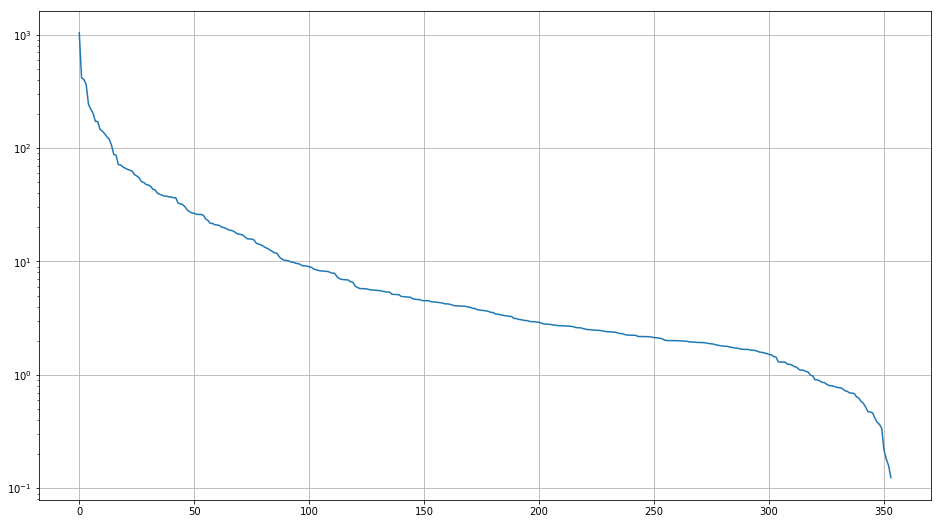

In [8]:
fi = pd.read_csv('feature_importance.csv', header=None)
fi.columns = ['feature', 'importance']
plt.figure(figsize=(16, 9))
plt.plot(fi.values[:, 1])
plt.grid()
plt.yscale('log')

In [7]:
fi

,0,1
0,ind_recibo_ult1_lag_1,1036.996064
1,ind_nomina_ult1_dist_neg_flank,414.853061
2,ind_nom_pens_ult1_dist_neg_flank,402.375667
3,ind_nom_pens_ult1_dist_first_one,363.697620
4,ind_cco_fin_ult1,243.616882
5,ind_nomina_ult1_p1,220.437511
6,ind_recibo_ult1_new,202.216888
7,ind_ctma_fin_ult1_p3,172.077784
8,ind_nom_pens_ult1_dist_last_one,171.410293
9,ind_cco_fin_ult1_new,146.242978
